In [2]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range
import matplotlib.pyplot as plt
import random
%matplotlib inline
print "Done"

Done


In [3]:
pickle_file = 'dataset.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

('Training set', (65000, 32, 32, 1), (65000,))
('Validation set', (5000, 32, 32, 1), (5000,))
('Test set', (10000, 32, 32, 1), (10000,))


Display some of the images just to make sure everything is fine

In [4]:
BATCH_SIZE=64
IMAGE_SIZE=32
N_CHANNELS=1
NUM_LABELS=10
LEARNING_RATE_DECAY_FACTOR = 0.1  # Learning rate decay factor.
INITIAL_LEARNING_RATE = 0.1       # Initial learning rate.

In [5]:
def display_images_at_random(dataset, labels):
    # random.seed(1)
    
    f, axarr = plt.subplots(3, 3, figsize=(8,8))
    
    for i in range(3):
        for j in range(3):
            img_rand_index = random.randrange(0,dataset.shape[0])
            axarr[i, j].imshow(dataset[img_rand_index].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap=plt.cm.Greys);
            axarr[i, j].set_title('Label: ' + str(labels[img_rand_index]) + " Index: " + str(img_rand_index))

    plt.show()

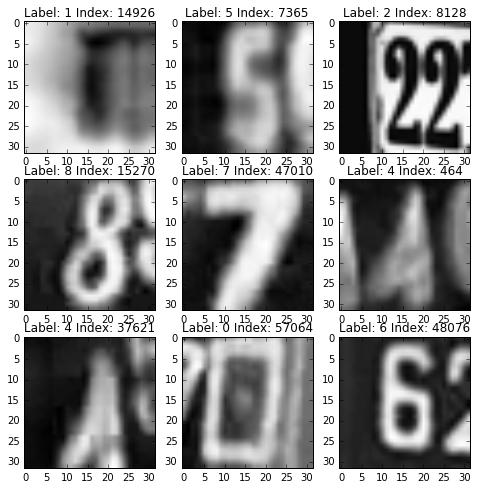

In [6]:
display_images_at_random(train_dataset, train_labels)

In [7]:
# verify if the data is well balanced across the classes
def display_data_distribution(labels):
    data_distribution = np.bincount(labels)

    index = np.arange(10)
    plt.bar(index, data_distribution)
    plt.title("Display the number of Samples per class label")
    plt.xlabel('Classes')
    plt.ylabel('Samples')

    bar_width = 0.35
    plt.xticks(index + bar_width, ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9'))

    plt.show()

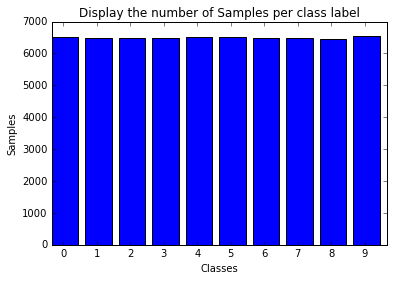

In [8]:
display_data_distribution(train_labels)

In [9]:
def reformat(dataset, labels):
  # Map 0 to [1.0, 0.0, 0.0 ...], 1 to [0.0, 1.0, 0.0 ...]
  labels = (np.arange(NUM_LABELS) == labels[:,None]).astype(np.float32)
  return dataset, labels

train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Train set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

('Train set', (65000, 32, 32, 1), (65000, 10))
('Validation set', (5000, 32, 32, 1), (5000, 10))
('Test set', (10000, 32, 32, 1), (10000, 10))


[ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]


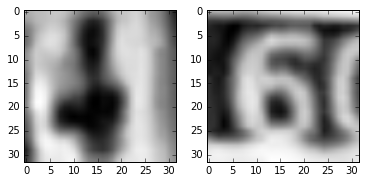

In [10]:
_, (ax1, ax2) = plt.subplots(1, 2)

img = train_dataset[2,:,:]
ax1.imshow(img.reshape(32,32), cmap=plt.cm.Greys);
print train_labels[2]

img = train_dataset[19757,:,:]
ax2.imshow(img.reshape(32,32), cmap=plt.cm.Greys);
print train_labels[19757]

In [11]:
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

('Training set', (65000, 32, 32, 1), (65000, 10))
('Validation set', (5000, 32, 32, 1), (5000, 10))
('Test set', (10000, 32, 32, 1), (10000, 10))


In [12]:
x = tf.placeholder(tf.float32, shape=[None, IMAGE_SIZE, IMAGE_SIZE, N_CHANNELS], name="train_dataset_planceholder")

y_ = tf.placeholder(tf.float32, shape=[BATCH_SIZE, NUM_LABELS], name="train_labels_placeholder")

tf_valid_dataset = tf.constant(valid_dataset, name="validation_dataset")
tf_valid_dataset = tf.cast(tf_valid_dataset, tf.float32)

tf_test_dataset = tf.constant(test_dataset, name="test_dataset")
tf_test_dataset = tf.cast(tf_test_dataset, tf.float32)

In [13]:
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(value=0.1, shape=shape)
  return tf.Variable(initial)

def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')
print "Done"

Done


In [14]:
W_conv1 = weight_variable([5, 5, N_CHANNELS, 32])
b_conv1 = bias_variable([32])

W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

keep_prob = tf.placeholder(tf.float32)

FC1_SIZE = 512
W_fc1 = weight_variable([8 * 8 * 64, FC1_SIZE])
b_fc1 = bias_variable([FC1_SIZE])

FC2_SIZE = 1024
W_fc2 = weight_variable([FC1_SIZE, FC2_SIZE])
b_fc2 = bias_variable([FC2_SIZE])

read_output_layer = weight_variable([FC2_SIZE, NUM_LABELS])
read_output_bias = bias_variable([NUM_LABELS])

In [15]:
def model(x_image):    
    h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
    h_pool1 = max_pool_2x2(h_conv1)

    h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
    h_pool2 = max_pool_2x2(h_conv2)

    shape = h_pool2.get_shape().as_list()  
    h_pool2_flat = tf.reshape(h_pool2, [-1, shape[1] * shape[2] * shape[3]])
    
    # First fully connected layer
    h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
    #h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)
    
    # Second fully connected layer
    h_fc2 = tf.nn.relu(tf.matmul(h_fc1, W_fc2) + b_fc2)
    #h_fc2_drop = tf.nn.dropout(h_fc2, keep_prob)

    return tf.matmul(h_fc2, read_output_layer) + read_output_bias

In [16]:
logits = model(x)
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, y_))

# apply L2 regularization of the trained weights
# regularizers = tf.nn.l2_loss(W_fc1) + tf.nn.l2_loss(W_fc2)
# loss += 1e-4 * regularizers 

# Add a scalar summary for the snapshot loss.
tf.scalar_summary(loss.op.name, loss)

# Create a variable to track the global step.
global_step = tf.Variable(0, name='global_step', trainable=False)

optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss, global_step=global_step)

# Predictions for the minibatch, validation set and test set.
train_prediction = tf.nn.softmax(logits)
valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
test_prediction = tf.nn.softmax(model(tf_test_dataset))

print "Done"

Done


In [17]:
# Create a new interactive session that we'll use in
# subsequent code cells.
s = tf.InteractiveSession()

# Use our newly created session as the default for 
# subsequent operations.
s.as_default()

# Initialize all the variables we defined above.
tf.initialize_all_variables().run()

In [18]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

In [ ]:
total_steps = int(train_labels.shape[0] / BATCH_SIZE)

for step in xrange(total_steps):
  offset = (step * BATCH_SIZE) % (train_labels.shape[0] - BATCH_SIZE)
  batch_data = train_dataset[offset:(offset + BATCH_SIZE), :, :, :]
  batch_labels = train_labels[offset:(offset + BATCH_SIZE), :]
  
  feed_dict = {x : batch_data, y_ : batch_labels, keep_prob : 0.5}
  
  # Run the graph and fetch some of the nodes.
  _, l, predictions = s.run([optimizer, loss, train_prediction], feed_dict=feed_dict)

  if step % 100 == 0:
    acc = accuracy(predictions, batch_labels)
    print('Minibatch loss at step %d: %f' % (step, l))
    print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
    print('Validation accuracy: %.1f%%' % accuracy(
           valid_prediction.eval({keep_prob : 1.0}), valid_labels))
    print ('Traning data amount used so far: %d : %d' % (offset, (offset + BATCH_SIZE)))
    print "=================================================="
print "Done training"

Minibatch loss at step 0: 10.483093
Minibatch accuracy: 7.8%
Validation accuracy: 10.0%
Traning data amount used so far: 0 : 64
Minibatch loss at step 100: 2.326169
Minibatch accuracy: 4.7%
Validation accuracy: 9.9%
Traning data amount used so far: 6400 : 6464
Minibatch loss at step 200: 2.301609
Minibatch accuracy: 17.2%
Validation accuracy: 9.8%
Traning data amount used so far: 12800 : 12864
Minibatch loss at step 300: 2.304782
Minibatch accuracy: 12.5%
Validation accuracy: 10.0%
Traning data amount used so far: 19200 : 19264
Minibatch loss at step 400: 2.377946
Minibatch accuracy: 3.1%
Validation accuracy: 10.2%
Traning data amount used so far: 25600 : 25664
Minibatch loss at step 500: 2.346724
Minibatch accuracy: 6.2%
Validation accuracy: 9.8%
Traning data amount used so far: 32000 : 32064
Minibatch loss at step 600: 2.254285
Minibatch accuracy: 14.1%
Validation accuracy: 12.7%
Traning data amount used so far: 38400 : 38464
Minibatch loss at step 700: 2.223505

In [19]:
def error_rate(predictions, labels):
  """Return the error rate and confusions."""
  correct = np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
  total = predictions.shape[0]

  error = 100.0 - (100 * float(correct) / float(total))

  confusions = np.zeros([10, 10], np.float32)
  bundled = zip(np.argmax(predictions, 1), np.argmax(labels, 1))
  for predicted, actual in bundled:
    confusions[predicted, actual] += 1
    
  return error, confusions

print 'Done'

Done


In [20]:
test_error, confusions = error_rate(test_prediction.eval({keep_prob : 1.0}), test_labels)
print 'Test error: %.1f%%' % test_error

ResourceExhaustedError: OOM when allocating tensor with shape[10000,32,32,32]
	 [[Node: add_10 = Add[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"](Conv2D_4, Variable_1/read)]]
Caused by op u'add_10', defined at:
  File "/usr/lib/python2.7/runpy.py", line 162, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python2.7/dist-packages/traitlets/config/application.py", line 589, in launch_instance
    app.start()
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelapp.py", line 405, in start
    ioloop.IOLoop.instance().start()
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/ioloop.py", line 162, in start
    super(ZMQIOLoop, self).start()
  File "/usr/local/lib/python2.7/dist-packages/tornado/ioloop.py", line 883, in start
    handler_func(fd_obj, events)
  File "/usr/local/lib/python2.7/dist-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 260, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 212, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 370, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/ipkernel.py", line 175, in do_execute
    shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2723, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2825, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2885, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-15-de8e1bc3f466>", line 28, in <module>
    test_prediction = tf.nn.softmax(model(tf_test_dataset))
  File "<ipython-input-14-ea2cee458849>", line 2, in model
    h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/math_ops.py", line 468, in binary_op_wrapper
    return func(x, y, name=name)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/gen_math_ops.py", line 44, in add
    return _op_def_lib.apply_op("Add", x=x, y=y, name=name)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/op_def_library.py", line 655, in apply_op
    op_def=op_def)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/ops.py", line 2040, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/ops.py", line 1087, in __init__
    self._traceback = _extract_stack()


In [ ]:
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.grid(False)
plt.xticks(np.arange(NUM_LABELS))
plt.yticks(np.arange(NUM_LABELS))
plt.imshow(confusions, cmap=plt.cm.jet, interpolation='nearest');

for i, cas in enumerate(confusions):
  for j, count in enumerate(cas):
    if count > 0:
      xoff = .07 * len(str(count))
      plt.text(j-xoff, i+.2, int(count), fontsize=9, color='white')
print 'Done'